In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import AUC, Precision, Recall
import pickle
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [94]:
# Charge X and y data that are in .npy format
X = np.load('../save_model/X.npy')
y = np.load('../save_model/y.npy')

In [82]:
# if y is 0 or 1, then is 0, if is 2 or 3, then is 1
#y = np.where(y < 2, 0, 1)

In [ ]:
X.shape, y.shape

((241, 300, 30), (241,))

In [187]:
import numpy as np

def augment_sequence(x, noise_std=0.01, max_shift=5, scale_range=(0.9, 1.1), window_size=10):
    """
    Aplica aumento de datos a una secuencia individual de forma (300, 30)
    """
    # 1. Agregar ruido gaussiano
    noise = np.random.normal(0, noise_std, x.shape)
    x_aug = x + noise

    # 2. Desplazamiento temporal (shift)
    shift = np.random.randint(-max_shift, max_shift + 1)
    x_aug = np.roll(x_aug, shift, axis=0)

    # 3. Escalado
    scale = np.random.uniform(scale_range[0], scale_range[1])
    x_aug = x_aug * scale

    # 4. Permutación de subventanas
    num_segments = x.shape[0] // window_size
    segments = np.array_split(x_aug[:num_segments * window_size], num_segments, axis=0)
    np.random.shuffle(segments)
    x_aug = np.concatenate(segments, axis=0)

    return x_aug


def augment_dataset(X, y, augment_factor=2):
    """
    Aumenta el dataset X, y multiplicando los datos por augment_factor
    """
    X_aug = []
    y_aug = []

    for i in range(len(X)):
        for _ in range(augment_factor):
            x_new = augment_sequence(X[i])
            X_aug.append(x_new)
            y_aug.append(y[i])

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    
    # Mezclamos con los originales si quieres:
    X_combined = np.concatenate([X, X_aug], axis=0)
    y_combined = np.concatenate([y, y_aug], axis=0)

    return X_combined, y_combined


In [188]:
X_augmented, y_augmented = augment_dataset(X, y, augment_factor=2)
print(X_augmented.shape)  # Debería ser (241 * 3, 300, 30)
print(y_augmented.shape)

(723, 300, 30)
(723,)


In [190]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42, stratify=y_augmented)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

((462, 300, 30), (116, 300, 30), (145, 300, 30), (462,), (116,), (145,))

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Primera división: train (70%) vs val+test (30%)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
for train_index, temp_index in sss1.split(X, y):
    X_train, X_temp = X[train_index], X[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# Segunda división: val (15%) y test (15%) a partir de temp
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)  # 50% de 30% = 15%
for val_index, test_index in sss2.split(X_temp, y_temp):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]

# Verificación de tamaños
print(f"Train: {X_train.shape}, {np.bincount(y_train.astype(int))}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {np.bincount(y_val.astype(int))}", f"{y_val.shape}")
print(f"Test:  {X_test.shape}, {np.bincount(y_test.astype(int))}", f"{y_test.shape}")

Train: (168, 300, 30), [41 42 42 43], (168,)
Val:   (36, 300, 30), [9 9 9 9] (36,)
Test:  (37, 300, 30), [ 9  9 10  9] (37,)


In [ ]:
#input_layer = Input(shape=(X_train.shape[1],))
#
#x = Dense(256, activation='relu')(input_layer)
#x = BatchNormalization()(x)
#x = Dropout(0.4)(x)
#
#x = Dense(128, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
#
#x = Dense(64, activation='relu')(x)
#x = BatchNormalization()(x)
#
## Solo 1 neurona con activación sigmoid
#output = Dense(1, activation='sigmoid')(x)
#
#model = Model(inputs=input_layer, outputs=output)
#
#model.compile(
#    optimizer=Adam(learning_rate=1e-4),
#    loss='binary_crossentropy',  # Cambio importante aquí
#    metrics=['accuracy']
#)

In [209]:
## Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
##reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
#
## Train the model
#history = model.fit(
#    X_train, y_train,
#    validation_data=(X_val, y_val),
#    epochs=1000,
#    batch_size=32,
#    callbacks=[early_stopping],
#    #class_weight=class_weights
#)

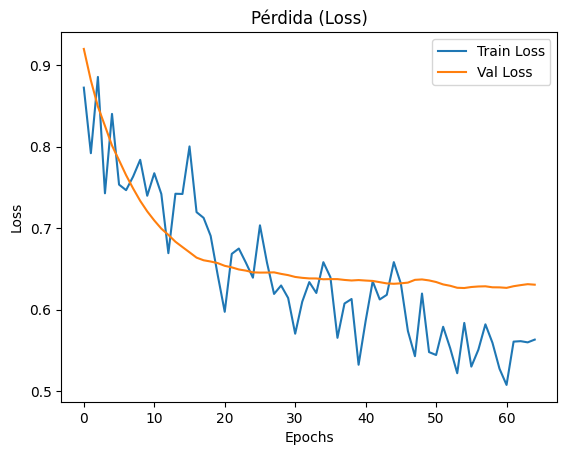

In [112]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

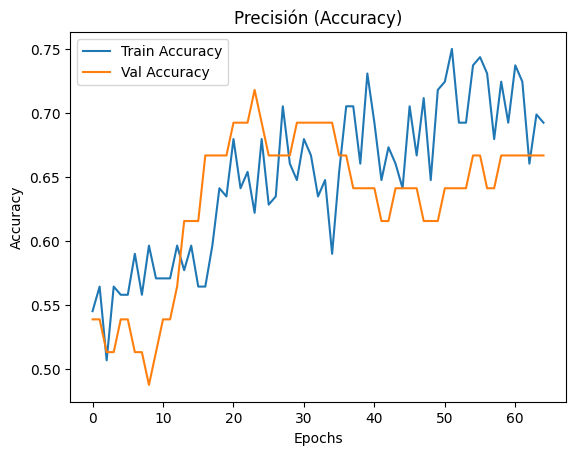

In [113]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Precisión (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


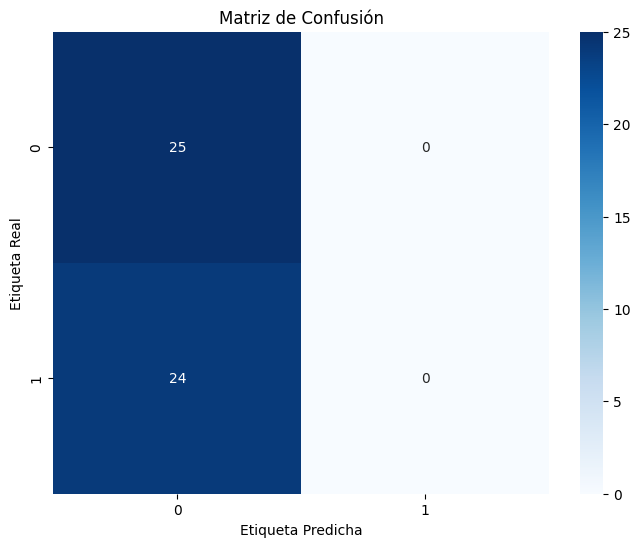

In [114]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [116]:
# Obtener el reporte de clasificación con zero_division
report = classification_report(y_test, y_pred)

# Imprimir el reporte
print(report)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68        25
           1       0.00      0.00      0.00        24

    accuracy                           0.51        49
   macro avg       0.26      0.50      0.34        49
weighted avg       0.26      0.51      0.34        49



d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Expandir dimensiones para canal (1)
X_train = np.expand_dims(X_train, axis=-1)  # (168, 300, 300, 1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Entrada: imágenes de 300x300 con 1 canal (escala de grises)
input_layer = Input(shape=(300, 30, 1))

# Extracción de características
x = Conv2D(32, kernel_size=5, activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=5, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=5, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, kernel_size=5, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.25)(x)

# Clasificación
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # 4 clases

# Crear modelo
model = Model(inputs=input_layer, outputs=output)

# Compilar modelo
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Ver resumen del modelo
model.summary()

ValueError: Computed output size would be negative. Received `inputs shape=(None, 34, 0, 128)`, `kernel shape=(5, 5, 128, 256)`, `dilation_rate=[1 1]`.

In [ ]:
#class_weights = class_weight.compute_class_weight(
#    class_weight='balanced',
#    classes=np.unique(y_train.flatten()),
#    y=y_train.flatten()
#)
#
#class_weights = {i: w for i, w in enumerate(class_weights)}

In [ ]:
#from imblearn.over_sampling import SMOTE
#
#sm = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
## view zeros and ones in y_train_resampled
#print("Train: ", y_train_resampled.sum(), "Val: ", y_val.sum(), "Test: ", y_test.sum())
#print("Train: ", y_train_resampled.shape[0], "Val: ", y_val.shape[0], "Test: ", y_test.shape[0])
#print("Train: ", y_train_resampled.shape[0] - y_train_resampled.sum(), "Val: ", y_val.shape[0] - y_val.sum(), "Test: ", y_test.shape[0] - y_test.sum())

Train:  5233 Val:  1537 Test:  1638
Train:  10466 Val:  1720 Test:  1723
Train:  5233 Val:  183 Test:  85


In [13]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=400, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=800,
    batch_size=4,
    callbacks=[early_stopping],
    #class_weight=class_weights
)

Epoch 1/800


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 300, 30, 1, 1, 1, 1), dtype=float32). Expected shape (None, 300, 30, 1), but input has incompatible shape (None, 300, 30, 1, 1, 1, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 300, 30, 1, 1, 1, 1), dtype=float32)
  • training=True
  • mask=None

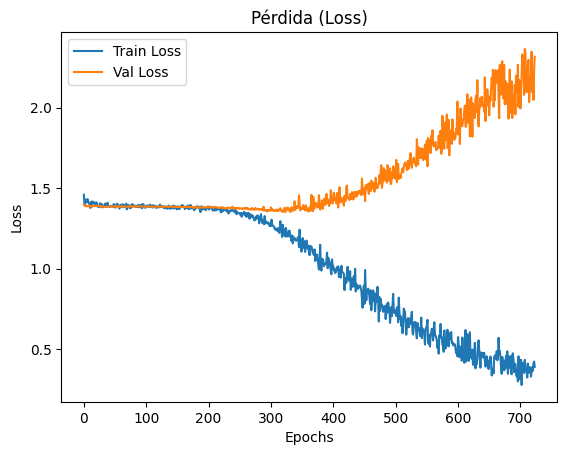

In [194]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

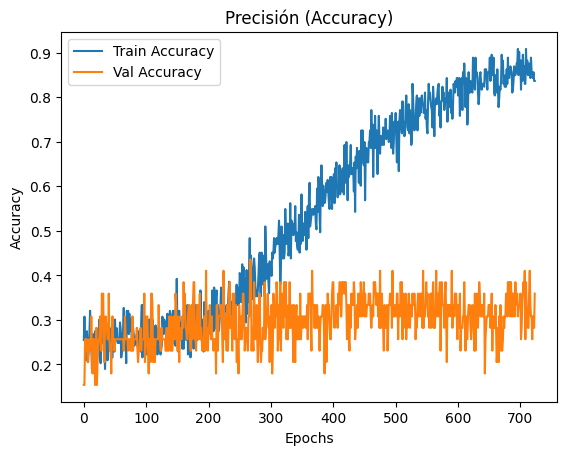

In [195]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Precisión (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


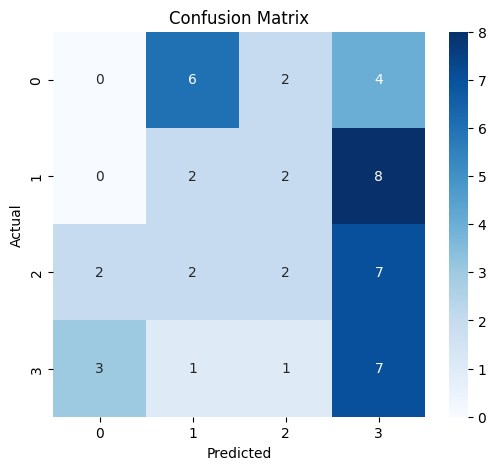

In [196]:
# 4 engagement
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)

# Opcional: Mostrar como heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [197]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        12
           1      0.182     0.167     0.174        12
           2      0.286     0.154     0.200        13
           3      0.269     0.583     0.368        12

    accuracy                          0.224        49
   macro avg      0.184     0.226     0.186        49
weighted avg      0.186     0.224     0.186        49



In [172]:
from sklearn.utils import class_weight

# Calcular pesos automáticamente
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [197]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Parámetros
n_components = 30  # número de componentes disponibles
n_models = 1      # número de modelos en el ensemble
components_per_model = 30  # cuantos componentes (features) por modelo

models = []
selected_components = []
histories = []

# Callback EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Definimos el modelo CNN
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    return model

# Entrenamiento de ensemble
for i in range(n_models):
    print(f"Entrenando modelo {i+1}/{n_models}")
    
    # Elegimos aleatoriamente componentes
    components_idx = np.random.choice(n_components, components_per_model, replace=False)
    selected_components.append(components_idx)
    
    # Seleccionamos esos componentes
    X_train_selected = X_train[:, :, components_idx]  # (samples, 300, components_per_model)
    X_val_selected = X_val[:, :, components_idx]

    # Creamos y entrenamos el modelo
    model = build_cnn_model((X_train_selected.shape[1], X_train_selected.shape[2]))
    
    history = model.fit(
        X_train_selected,
        y_train,
        class_weight=class_weights,
        epochs=500,
        batch_size=32,
        validation_data=(X_val_selected, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    models.append(model)
    histories.append(history)

Entrenando modelo 1/1
Epoch 1/500


d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2404 - loss: 6.3012 - val_accuracy: 0.3190 - val_loss: 2.5406 - learning_rate: 5.0000e-04
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2721 - loss: 2.9496 - val_accuracy: 0.3793 - val_loss: 1.5765 - learning_rate: 5.0000e-04
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3598 - loss: 1.7979 - val_accuracy: 0.3448 - val_loss: 1.8321 - learning_rate: 5.0000e-04
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3041 - loss: 1.6100 - val_accuracy: 0.2931 - val_loss: 1.6900 - learning_rate: 5.0000e-04
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3139 - loss: 1.4262 - val_accuracy: 0.3793 - val_loss: 1.4239 - learning_rate: 5.0000e-04
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.2835 - loss: 1.4134 - val_accuracy: 0.3879 - val_loss: 1.3963 - learning_rate: 5.0000e-04
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3188 - los

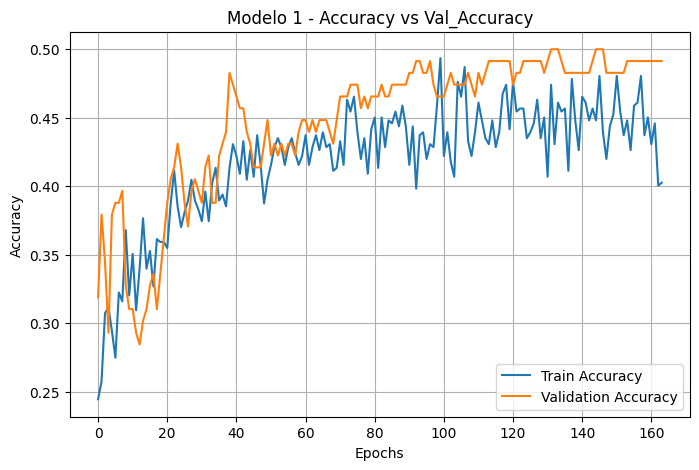

In [198]:
# Graficar accuracy de cada modelo
for i, history in enumerate(histories):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Modelo {i+1} - Accuracy vs Val_Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [199]:
# Predicciones individuales de cada modelo
all_model_preds = []

for idx, model in enumerate(models):
    components_idx = selected_components[idx]
    X_test_selected = X_test[:, :, components_idx]
    
    preds = model.predict(X_test_selected)
    all_model_preds.append(preds)

# Stack de predicciones
all_model_preds = np.stack(all_model_preds, axis=0)  # (n_models, n_samples, 4)

# Promedio (soft voting)
avg_preds = np.mean(all_model_preds, axis=0)  # (n_samples, 4)

# Predicción final: clase con mayor probabilidad
final_preds = np.argmax(avg_preds, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


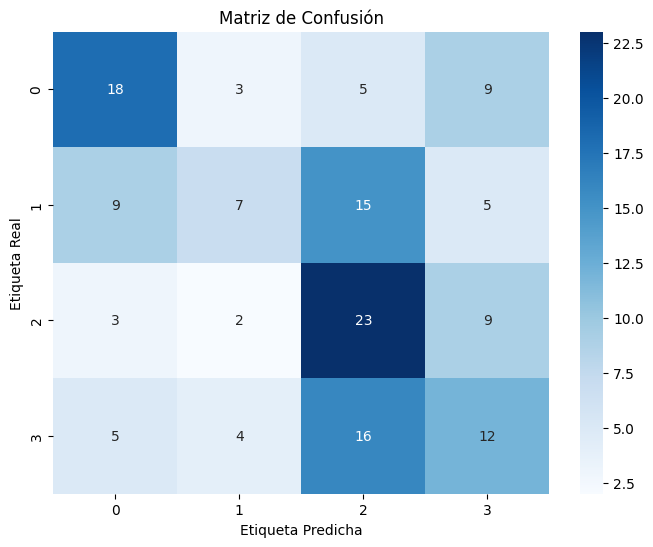

In [200]:
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [201]:
# view classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.514     0.514     0.514        35
           1      0.438     0.194     0.269        36
           2      0.390     0.622     0.479        37
           3      0.343     0.324     0.333        37

    accuracy                          0.414       145
   macro avg      0.421     0.414     0.399       145
weighted avg      0.420     0.414     0.398       145

